In [1]:
%load_ext autoreload
%autoreload 2

# Decision Tree

In [ ]:
%writefile utils_fun.py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import tree


class GetTitanicDataset:
    def __init__(self, df: pd.DataFrame = None, **kwargs):
        self.df = df
        self.path = kwargs.get('path')
        self.col_to_drop = kwargs.get('col_to_drop')
        self.col_dtype = kwargs.get('col_dtype')

        if not self.df:
            self.get_data()

    def __call__(self):
        self.prepare_dataset()
        self.change_dtype()
        return self.get_data_target()

    def get_data(self):
        if not self.path:
            self.path = "https://raw.githubusercontent.com/Kamil128/Learning_repo/main/ML_Classification/data/titanic_train.csv"
        self.df = pd.read_csv(self.path)

    def prepare_dataset(self):
        if not self.col_to_drop:
            self.col_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
        self.df.drop(self.col_to_drop, axis=1, inplace=True)

    def change_dtype(self):

        if not self.col_dtype:
            self.col_dtype = {
                'Sex': 'category',
                'Age': 'int',
                'Embarked': 'category',
                'Survived': 'category',
                'Pclass': 'category',
            }

        for col, dtype in self.col_dtype.items():
            self.df[col] = self.df[col].astype(dtype, errors='ignore')

    def get_data_target(self):
        return self.df.drop(['Survived'], axis=1), self.df['Survived']


def show_decision_path(estimator):
    clf = estimator

    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
        else:
            print(
                "{space}node={node} is a split node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )

    ##############################################################################
    # We can compare the above output to the plot of the decision tree.

    plt.figure(figsize=(15, 7))
    tree.plot_tree(clf, node_ids=True)
    plt.show()


def show_decision_sample(estimator, x, transformer=None):

    if transformer:
        x = transformer.transform(x)

    clf = estimator

    node_indicator = clf.decision_path(x)
    leaf_id = clf.apply(x)
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    n_nodes = clf.tree_.node_count

    sample_id = 0
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
                 node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]
                 ]

    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        # check if value of the split feature for sample 0 is below threshold
        if x[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print(
            "decision node {node} : (x[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=x[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )

    ##############################################################################
    # For a group of samples, we can determine the common nodes the samples go
    # through.

    sample_ids = [0, 1]
    # boolean array indicating the nodes both samples go through
    common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
    # obtain node ids using position in array
    common_node_id = np.arange(n_nodes)[common_nodes]

    print(
        "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
            samples=sample_ids, nodes=common_node_id
        )
    )
    print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / n_nodes))


# Load Dataset

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils_fun import GetTitanicDataset, show_decision_path, show_decision_sample

In [53]:
titanic = GetTitanicDataset()
X, y = titanic()

# Train Test Split

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42,
                                                    stratify=y)

In [55]:
num_attr = X_train.select_dtypes(include='number').columns
cat_attr = X_train.select_dtypes(exclude='number').columns

In [56]:
from sklearn.preprocessing import KBinsDiscretizer

kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')

age = kbins.fit_transform(X_train[['Age']].fillna(28))
age[:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [57]:
kbins.bin_edges_

array([array([ 0.42 , 20.315, 40.21 , 60.105, 80.   ])], dtype=object)

In [58]:
pd.DataFrame({'kbins': age.flatten(), 'age': X_train['Age'].fillna(28).values})

,kbins,age
0,1.0,28.0
1,1.0,28.0
2,1.0,28.0
3,0.0,18.0
4,1.0,31.0
...,...,...
707,1.0,28.0
708,1.0,35.0
709,2.0,48.0
710,2.0,47.0


In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer


num_pipeline = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='median')),
     # ('standard_scaller', StandardScaler()),
     ('discr', KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform')),
     ('ohe', OneHotEncoder(sparse=False)),
    ]
)

cat_pipeline = Pipeline(
    [
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('ohe', OneHotEncoder(sparse=False)),
    ]
)

cat_num_pipeline = ColumnTransformer(
    transformers=
    [
     ('numerical', num_pipeline, num_attr),
     ('categorical', cat_pipeline, cat_attr)
    ]
)

In [60]:
cat_num_pipeline.fit_transform(X_train)

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [75]:
from sklearn.tree import DecisionTreeClassifier

train_pipeline = Pipeline(
    [
        ('cat_num_pipeline', cat_num_pipeline),
        ('model', DecisionTreeClassifier(max_depth=3))
    ]
)

In [76]:
train_pipeline.fit(X_train, y_train)

Pipeline(steps=[('cat_num_pipeline',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('discr',
                                                                   KBinsDiscretizer(encode='onehot-dense',
                                                                                    n_bins=3,
                                                                                    strategy='uniform')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['Age', 'SibSp', 'Parch', 'Fare'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index(['Pclass', 'Sex', 'Embarked'], dtype='object'))])),
                ('model', DecisionTreeClassifier(max_depth=3))])

In [77]:
y_pred = train_pipeline.predict(X_test)
y_train_pred = train_pipeline.predict(X_train)

In [78]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       110
           1       0.86      0.55      0.67        69

    accuracy                           0.79       179
   macro avg       0.82      0.75      0.76       179
weighted avg       0.81      0.79      0.78       179



In [79]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.79      0.95      0.86       439
           1       0.89      0.59      0.71       273

    accuracy                           0.82       712
   macro avg       0.84      0.77      0.79       712
weighted avg       0.83      0.82      0.81       712



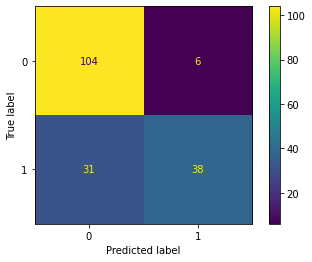

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(train_pipeline, X_test, y_test)
plt.show()

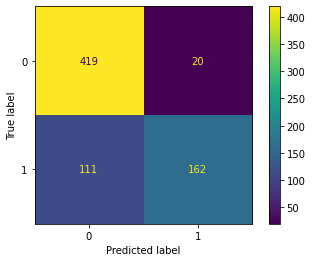

In [81]:
ConfusionMatrixDisplay.from_estimator(train_pipeline, X_train, y_train)
plt.show()

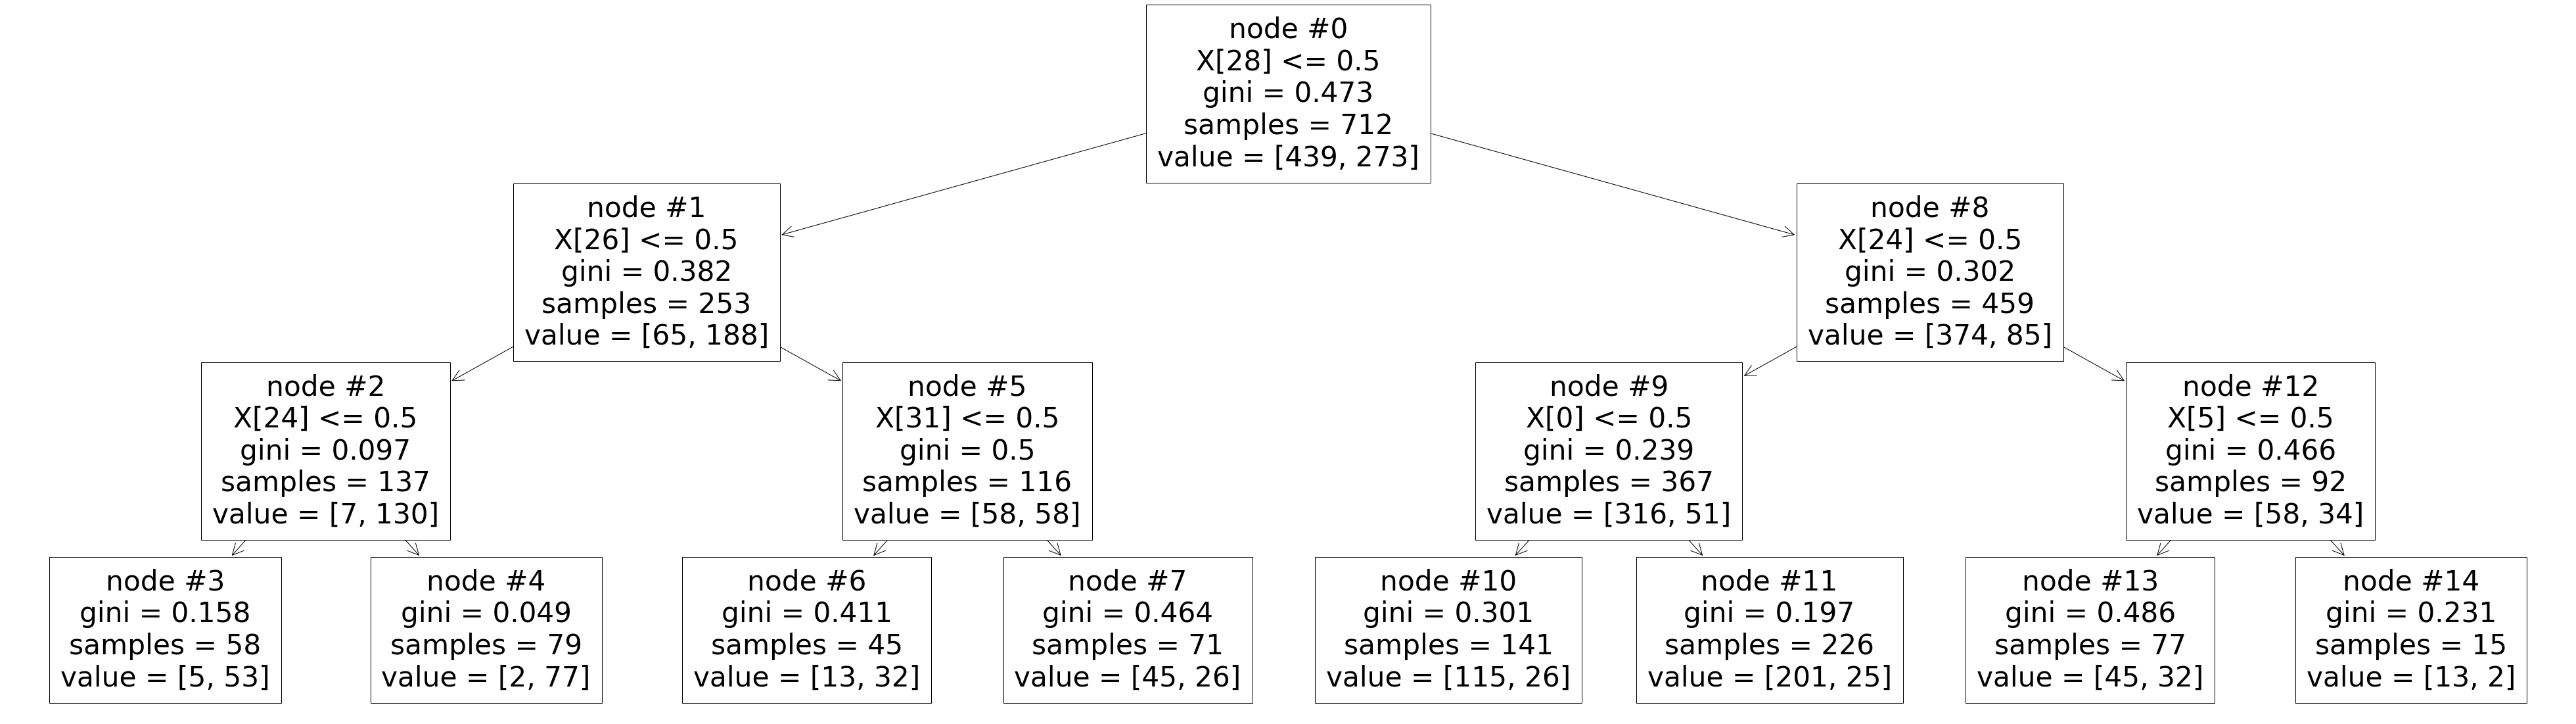

In [82]:
from sklearn.tree import plot_tree

plt.figure(figsize=(70, 20))
plot_tree(train_pipeline['model'], node_ids=True)
plt.show()

In [94]:
26/(115+26)

0.18439716312056736

In [90]:
train_pipeline.predict_proba(X_test)

array([[0.81560284, 0.18439716],
       [0.88938053, 0.11061947],
       [0.81560284, 0.18439716],
       [0.88938053, 0.11061947],
       [0.28888889, 0.71111111],
       [0.63380282, 0.36619718],
       [0.0862069 , 0.9137931 ],
       [0.58441558, 0.41558442],
       [0.58441558, 0.41558442],
       [0.88938053, 0.11061947],
       [0.88938053, 0.11061947],
       [0.81560284, 0.18439716],
       [0.63380282, 0.36619718],
       [0.88938053, 0.11061947],
       [0.58441558, 0.41558442],
       [0.81560284, 0.18439716],
       [0.63380282, 0.36619718],
       [0.88938053, 0.11061947],
       [0.81560284, 0.18439716],
       [0.0862069 , 0.9137931 ],
       [0.88938053, 0.11061947],
       [0.0862069 , 0.9137931 ],
       [0.88938053, 0.11061947],
       [0.63380282, 0.36619718],
       [0.88938053, 0.11061947],
       [0.02531646, 0.97468354],
       [0.88938053, 0.11061947],
       [0.58441558, 0.41558442],
       [0.88938053, 0.11061947],
       [0.88938053, 0.11061947],
       [0.

In [83]:
train_pipeline['model'].apply(
train_pipeline['cat_num_pipeline'].transform(X_test)
)

array([10, 11, 10, 11,  6,  7,  3, 13, 13, 11, 11, 10,  7, 11, 13, 10,  7,
       11, 10,  3, 11,  3, 11,  7, 11,  4, 11, 13, 11, 11, 11,  4, 11, 10,
       10, 10, 10,  7, 11,  3, 14,  4, 11,  3,  3, 10, 11,  7,  6,  3,  4,
        7,  6, 11, 13, 10, 11, 13,  7, 13,  6,  3, 10, 11, 13,  7,  4, 11,
       14, 10,  4, 11,  6,  4, 11, 11, 11, 10,  7,  7, 10, 11, 11, 10,  6,
       13, 11,  7, 13,  4, 13, 13, 11, 11, 13,  3,  3, 11, 11, 10, 14,  4,
        6,  3, 10, 13, 10, 11, 10, 13, 11, 11, 11, 14,  4, 11, 10, 10, 10,
       14, 11,  3, 11,  7, 10, 10, 13,  7, 10, 13, 11, 11,  6, 11, 10, 10,
        4, 11,  6, 11, 13, 10, 13, 13, 10, 14, 11, 10,  3,  3, 11, 10,  4,
        6, 14,  7, 11, 10, 10,  4, 13,  4,  6,  4,  3,  7, 11, 13,  3,  7,
       11, 11, 13, 10,  3, 10, 11,  3, 11])

In [84]:
decision_pat = train_pipeline['model'].decision_path(
train_pipeline['cat_num_pipeline'].transform(X_test)
).toarray()

In [85]:
decision_pat[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [86]:
pd.DataFrame(train_pipeline['cat_num_pipeline'].transform(X_test))

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
175,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
176,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
177,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 28] <= 0.5 else to node 8.
	node=1 is a split node: go to node 2 if X[:, 26] <= 0.5 else to node 5.
		node=2 is a split node: go to node 3 if X[:, 24] <= 0.5 else to node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5 is a split node: go to node 6 if X[:, 31] <= 0.5 else to node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8 is a split node: go to node 9 if X[:, 24] <= 0.5 else to node 12.
		node=9 is a split node: go to node 10 if X[:, 0] <= 0.5 else to node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[:, 5] <= 0.5 else to node 14.
			node=13 is a leaf node.
			node=14 is a leaf node.


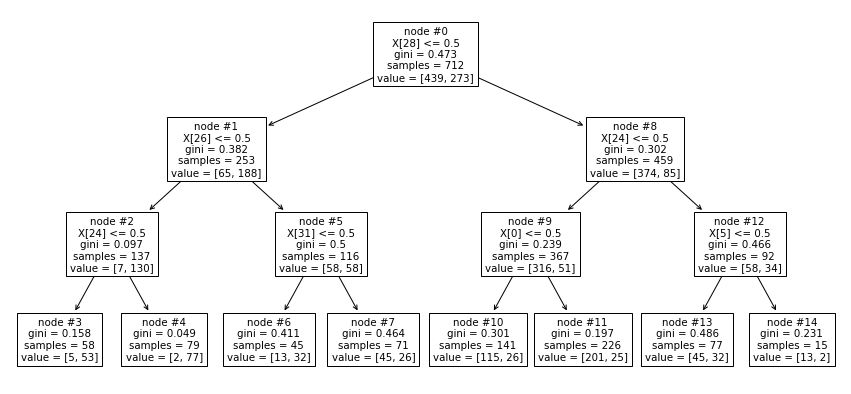

In [87]:
show_decision_path(train_pipeline['model'])

In [88]:
show_decision_sample(train_pipeline['model'], X_test, train_pipeline['cat_num_pipeline'])

Rules used to predict sample 0:

decision node 0 : (x[0, 28] = 1.0) > 0.5)
decision node 8 : (x[0, 24] = 0.0) <= 0.5)
decision node 9 : (x[0, 0] = 0.0) <= 0.5)

The following samples [0, 1] share the node(s) [0 8 9] in the tree.
This is 20.0% of all nodes.
